In [2]:
import numpy as np
import matplotlib.pyplot as plt
#%pip install git+https://github.com/alemartinello/dstapi

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# user written modules
import pandas as pd

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# APIs
from dstapi import DstApi

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
# Download and clean data
EJ56 = DstApi('EJ56')
params = {
    'table': 'EJ56', 'format': 'BULK', 'lang': 'da',
    'variables': [
        {'code': 'OMRÅDE', 'values': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11']},
        {'code': 'EJENDOMSKATE', 'values': ['0111', '0801', '2103']},
        {'code': 'TAL', 'values': ['100']},
        {'code': 'Tid', 'values': ['*']}
    ]
}

df = EJ56.get_data(params=params)
df = df.replace('..', np.nan).dropna(subset=['INDHOLD'])
df['INDHOLD'] = df['INDHOLD'].str.replace(',', '.').astype(float)
df = df.rename(columns={'INDHOLD': 'Indeks', 'TID': 'Kvartal', 'OMRÅDE': 'Landsdel', 'EJENDOMSKATE': 'Ejendomskategori'})

# Extract time and filter complete series
df['År'] = df['Kvartal'].str[:4].astype(int)
df['Kvartal_nr'] = df['Kvartal'].str[-1].astype(int)
df = df.sort_values(['Landsdel', 'Ejendomskategori', 'År', 'Kvartal_nr']).reset_index(drop=True)

earliest_quarter = df['Kvartal'].min()
landsdele_to_keep = [
    (l, e) for e in df['Ejendomskategori'].unique() 
    for l in df[df['Ejendomskategori'] == e]['Landsdel'].unique()
    if df[(df['Landsdel'] == l) & (df['Ejendomskategori'] == e)]['Kvartal'].min() == earliest_quarter
]
df = df[df.apply(lambda row: (row['Landsdel'], row['Ejendomskategori']) in landsdele_to_keep, axis=1)].reset_index(drop=True)

# Reindex to 1992Q1 = 100
df['Indeks_1992'] = df.groupby(['Landsdel', 'Ejendomskategori'], group_keys=False)['Indeks'].apply(lambda x: (x / x.iloc[0]) * 100)



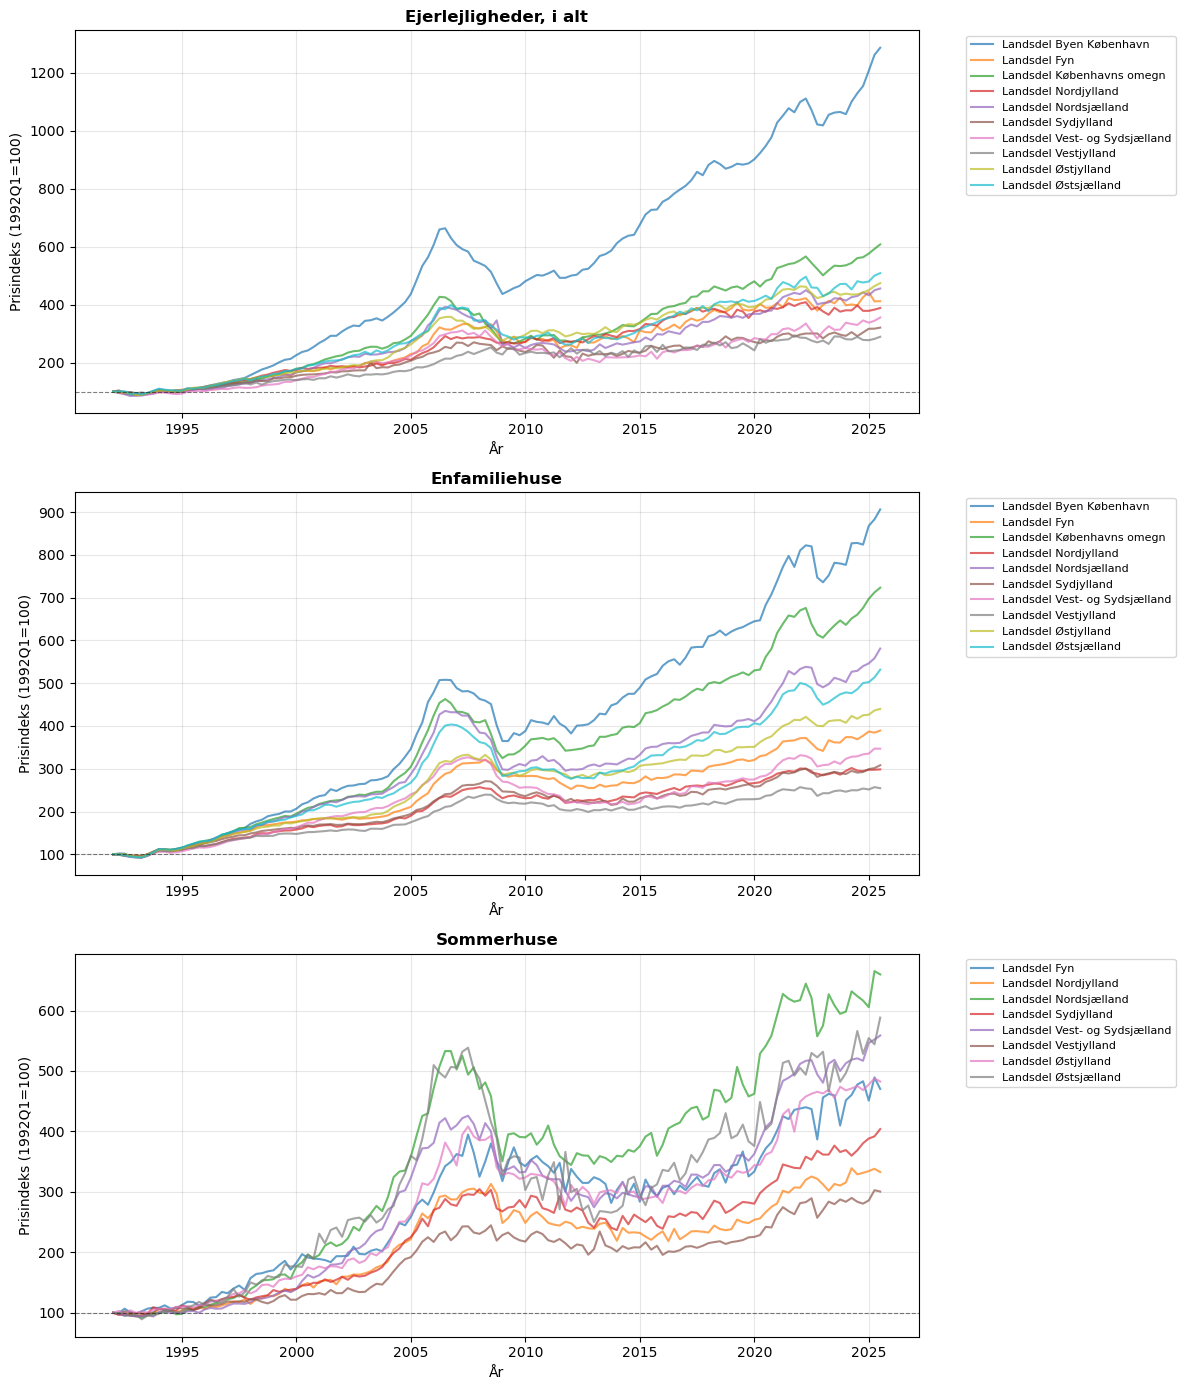

In [ ]:
# Plotting the property price development
fig, axes = plt.subplots(3, 1, figsize=(12, 14))

for idx, prop_type in enumerate(df['Ejendomskategori'].unique()):
    ax = axes[idx]
    df_prop = df[df['Ejendomskategori'] == prop_type]
    
    for landsdel in sorted(df_prop['Landsdel'].unique()):
        df_plot = df_prop[df_prop['Landsdel'] == landsdel].sort_values(['År', 'Kvartal_nr'])
        ax.plot(df_plot['År'] + (df_plot['Kvartal_nr']-1)/4, df_plot['Indeks_1992'], label=landsdel, alpha=0.7)
    
    ax.set_title(f'{prop_type}', fontsize=12, fontweight='bold')
    ax.set_xlabel('År')
    ax.set_ylabel('Prisindeks (1992Q1=100)')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    ax.grid(True, alpha=0.3)
    ax.axhline(y=100, color='black', linestyle='--', alpha=0.5, linewidth=0.8)

plt.tight_layout()
plt.show()


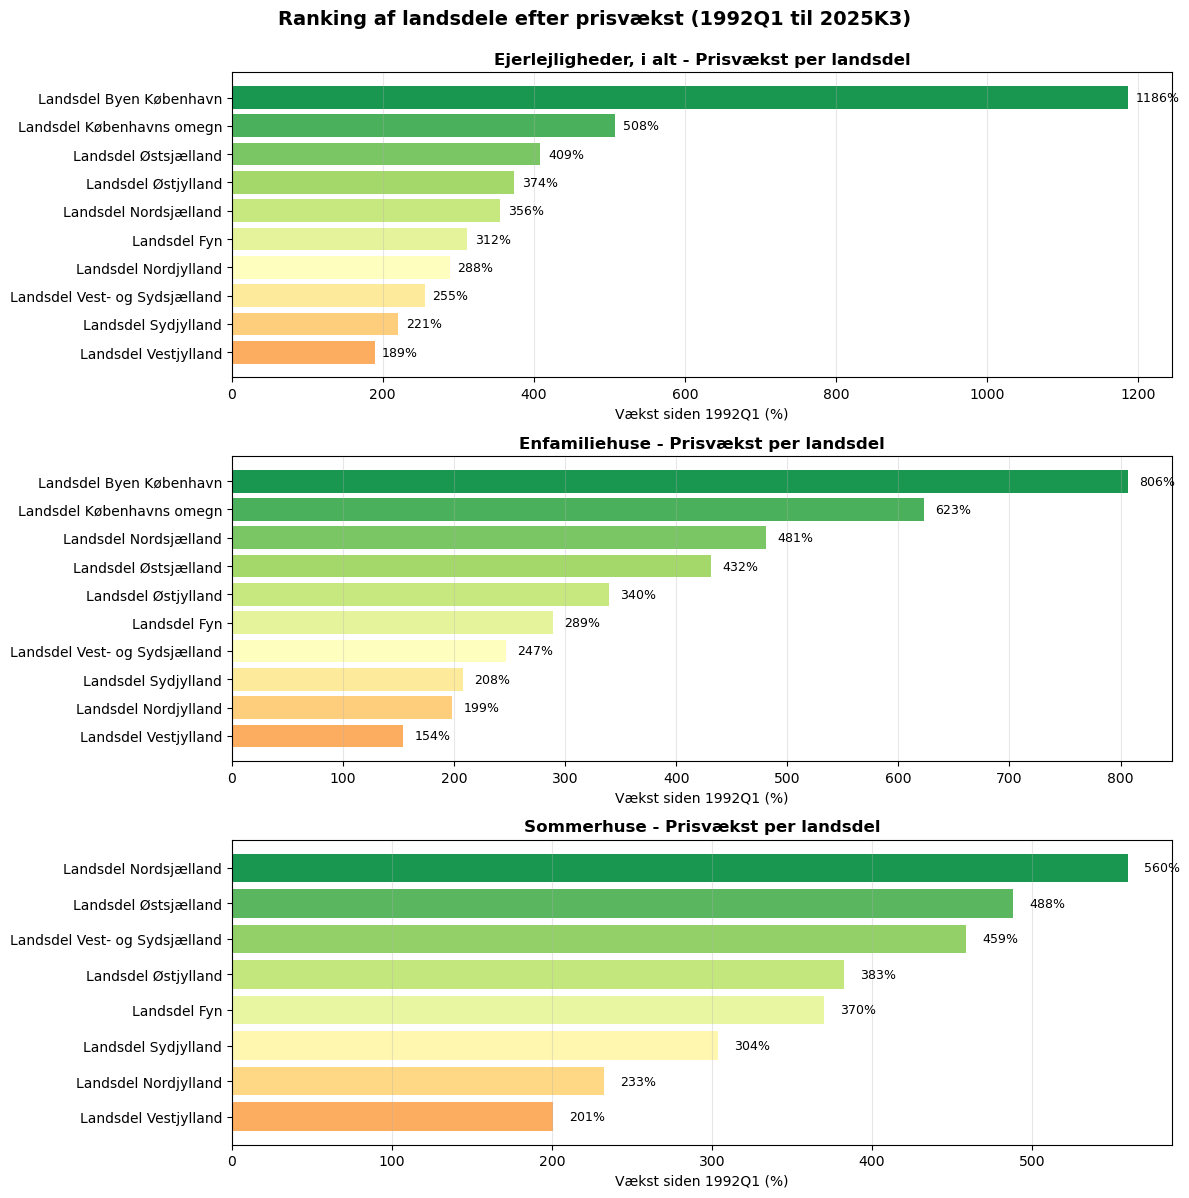

In [ ]:
# Ranking of landsdele by price growth
latest_data = df[df['Kvartal'] == df['Kvartal'].max()].copy()
latest_data['Vækst (%)'] = latest_data['Indeks_1992'] - 100

fig, axes = plt.subplots(3, 1, figsize=(12, 12))

for idx, ejendom in enumerate(sorted(latest_data['Ejendomskategori'].unique())):
    df_rank = latest_data[latest_data['Ejendomskategori'] == ejendom].sort_values('Indeks_1992', ascending=True)
    ax = axes[idx]
    colors = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(df_rank)))
    ax.barh(df_rank['Landsdel'], df_rank['Vækst (%)'], color=colors)
    ax.set_xlabel('Vækst siden 1992Q1 (%)', fontsize=10)
    ax.set_title(f'{ejendom} - Prisvækst per landsdel', fontsize=12, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
    
    for i, (landsdel, vækst) in enumerate(zip(df_rank['Landsdel'], df_rank['Vækst (%)'])):
        ax.text(vækst + 10, i, f'{vækst:.0f}%', va='center', fontsize=9)

plt.suptitle(f'Ranking af landsdele efter prisvækst (1992Q1 til {df["Kvartal"].max()})', fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

It can be seen that for both apartments and one family houses, "Landsdel København" is the province that experienced the biggest growth over the period. For summerhouses it is "landsdel Nordsjæland" that had the highest growt in prices over the periode.